# **ALE - Accumulated Local Effects**

#### Import packages and manipulation functions

In [ ]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from itertools import repeat, chain
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm
from lightgbm import LGBMRegressor
import shap
import scipy.sparse
import alibi

style.use('seaborn-v0_8-ticks')
plt.rcParams.update({'figure.facecolor':'white'})
sns.set_theme(style="ticks")

import os
from pathlib import Path

# Store the original directory path in a global variable if it doesn't exist yet
if not hasattr(__builtins__, '_original_dir'):
    __builtins__._original_dir = os.getcwd()
    root_dir = Path(__builtins__._original_dir).resolve().parent
    os.chdir(root_dir)
    print(f"Changed working directory to: {os.getcwd()}")
else:
    print(f"Directory already changed. Current working directory: {os.getcwd()}")

from utils.data_preparation import preprocess_data, split_data, mapping, determine_unit
from processing.custom_metrics import nash_sutcliffe, kling_gupta

Changed working directory to: C:\Users\xkorpijo3\OneDrive - Fortum\Desktop\Master-thesis-GBRT-dam


In [2]:
color = '\033[1m\033[38;5;208m' 
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version SHAP: {shap.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
print(f"{color}Version seasborn: {sns.__version__}")

Version scikit-learn: 1.5.2
Version lightgbm: 4.5.0
Version SHAP: 0.46.0
Version pandas: 2.2.3
Version numpy: 1.26.4
Version seasborn: 0.13.2


### **Define target/model of analysis**

In [39]:
target_name = 'GV51'

In [8]:
model_name = 'LightGBM'

In [9]:
features = ['h', 'h_MA_060', 'h_MA_180',
            'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
            'P', 'P_RS_180',
            'Q', 'Q_RS_030', 'Q_RS_120',
            't', 'month']

# features = ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18',
#             'h', 'h_MA_060', 'h_MA_180',
#             'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
#             'P', 'P_RS_180',
#             'Q', 'Q_RS_030', 'Q_RS_120',
#             't', 'month']


all_features_grouped = {
    'Reservoir level': ['h', 'h_MA_060', 'h_MA_180',],
    'Air Temperature': ['TA', 'TA_MA_180'],
    'Lagged Air Temperature': ['TA_lag_060', 'TA_lag_090'],
    'Precipitation': ['P'],
    'Accumulated Precipitation': ['P_RS_180'],
    'Local Inflow': ['Q'],
    'Accumulated Local Inflow': ['Q_RS_090', 'Q_RS_120'],
    'Temporal features': ['t', 'month'],
    # 'GV1': ['GV1'], 
    # 'GV3': ['GV3'], 
    # 'GV51': ['GV51'],
    # 'MB4': ['MB4'], 
    # 'MB8': ['MB8'], 
    # 'MB10': ['MB10'],
    # 'MB18': ['MB18']
}

feature_categories = {
    'Response': ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18'],
    'Environmental': ['h', 'h_MA_060', 'h_MA_180',
                     'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
                     'P', 'P_RS_180',
                     'Q', 'Q_RS_030', 'Q_RS_120',
                     't', 'month']
}

features_derived = {
    'Original': ['GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18', 'h', 'TA', 'P', 'Q'],
    'Environmental': ['h_MA_060', 'h_MA_180',
                     'TA_MA_180', 'TA_lag_060', 'TA_lag_090', 
                     'P_RS_180',
                     'Q_RS_030', 'Q_RS_120',
                     't', 'month']
}

In [40]:
test_size = 0.2
poly_degree = 0

if target_name in features: features.remove(target_name)
if target_name in all_features_grouped: del all_features_grouped[target_name]
path = f'./data/LOS_DAMM_{mapping(target_name)}.csv'
data = pd.read_csv(path, sep=';', parse_dates=['Date-Time'])

# Extract start and end dates
dates = data['Date-Time']
start_date = dates.iloc[0].date()  # First date (YYYY-MM-DD)
end_date = dates.iloc[-1].date()  # Last date (YYYY-MM-DD)

# Preprocess the data (You would need to define preprocess_data elsewhere in your code)
X, y, dates = preprocess_data(features, target_name, start_date, end_date, poly_degree=poly_degree, test_size=test_size)

# Split the data into training and testing sets (Assumes split_data is defined elsewhere)
X_train, X_test, y_train, y_test, split_index = split_data(X, y, test_size=test_size)

print("data loaded")

with open(f'./visualization/models/{model_name}/{model_name}_model_{target_name}.pkl', 'rb') as f:
    model = pickle.load(f)

print(f"{target_name} {model_name} loaded")

X_ALE = X[120*24:] # FOR LAGGED VARIABLES, REMOVE FIRST 120 DAYS

data loaded
GV51 LightGBM loaded


In [43]:
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.8552996267089586,
              learning_rate=0.03286202028083, linear_tree=False, max_depth=6,
              min_split_gain=0.6280661793078444, n_estimators=2951,
              num_leaves=3, reg_alpha=2.5137862899800223,
              reg_lambda=3.9430716192876, subsample=0.49235297280952,
              verbose=-1)

#### Sanity check that model is correct and predicts well

In [12]:
print("Feature names:")
print(X.columns, '\n')

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
all_predictions = model.predict(X)
ALE_predictions = model.predict(X_ALE)

rmse_train = np.sqrt(mean_squared_error(y_train, train_predictions))
rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
mae_test = mean_absolute_error(y_test, test_predictions)
NSE_test = nash_sutcliffe(y_test, test_predictions)
KGE_test = kling_gupta(y_test, test_predictions)

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("MAE Test:", mae_test)
print("NSE Test:", NSE_test)
print("KGE Test:", KGE_test)

Feature names:
Index(['t', 'month', 'h', 'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180',
       'TA_lag_060', 'TA_lag_090', 'P', 'P_RS_180', 'Q', 'Q_RS_030',
       'Q_RS_120'],
      dtype='object') 

RMSE Train: 0.15384411588778826
RMSE Test: 0.5383597627773131
MAE Test: 0.4368273770811632
NSE Test: 0.9838355342299463
KGE Test: 0.9471330536560743


# ALE

## EFFCETOR

In [12]:
import effector

In [13]:
def predict(x):
    return np.array(model.predict(x))

In [14]:
ALE = effector.ALE(data=X_test.values, model=predict, feature_names=np.array(X_test.columns), target_name=np.array(target))

In [15]:
print(X_test.columns)

Index(['t', 'month', 'GV1', 'GV3', 'MB4', 'MB8', 'MB10', 'MB18', 'h',
       'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090',
       'P', 'P_RS_180', 'Q', 'Q_RS_030', 'Q_RS_120'],
      dtype='object')


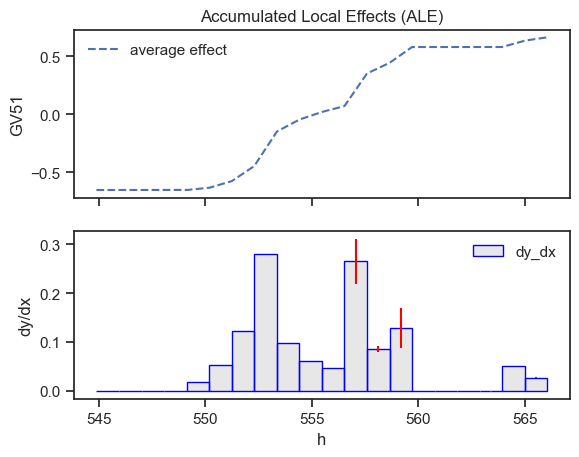

In [16]:
ALE.plot(8, heterogeneity=True)

In [19]:
print(X_ALE.columns)
xs = X_ALE['h'].to_numpy()

y_GV51_vs_h_ALE = ALE.eval(8, xs=xs)
print(np.std(y_GV51_vs_h_ALE))

Index(['t', 'month', 'GV1', 'GV3', 'MB4', 'MB8', 'MB10', 'MB18', 'h',
       'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180', 'TA_lag_060', 'TA_lag_090',
       'P', 'P_RS_180', 'Q', 'Q_RS_030', 'Q_RS_120'],
      dtype='object')
0.49403938775750905


Feature t (index 0): STD = 0.0000, Range = 0.0000
Feature month (index 1): STD = 0.0013, Range = 0.0046
Feature GV1 (index 2): STD = 1.5199, Range = 3.7740
Feature GV3 (index 3): STD = 1.6706, Range = 4.9219
Feature MB4 (index 4): STD = 0.0713, Range = 0.2011
Feature MB8 (index 5): STD = 0.0240, Range = 0.0701
Feature MB10 (index 6): STD = 0.0068, Range = 0.0222
Feature MB18 (index 7): STD = 0.0108, Range = 0.0513
Feature h (index 8): STD = 0.4169, Range = 1.3154
Feature h_MA_060 (index 9): STD = 0.5891, Range = 1.7465
Feature h_MA_180 (index 10): STD = 0.0465, Range = 0.1987
Feature TA (index 11): STD = 0.0130, Range = 0.0349
Feature TA_MA_180 (index 12): STD = 0.0238, Range = 0.0862
Feature TA_lag_060 (index 13): STD = 0.0230, Range = 0.0636
Feature TA_lag_090 (index 14): STD = 0.0094, Range = 0.0428
Feature P (index 15): STD = 0.0014, Range = 0.0143
Feature P_RS_180 (index 16): STD = 0.0328, Range = 0.1177
Feature Q (index 17): STD = 0.0374, Range = 0.1311
Feature Q_RS_030 (index 18

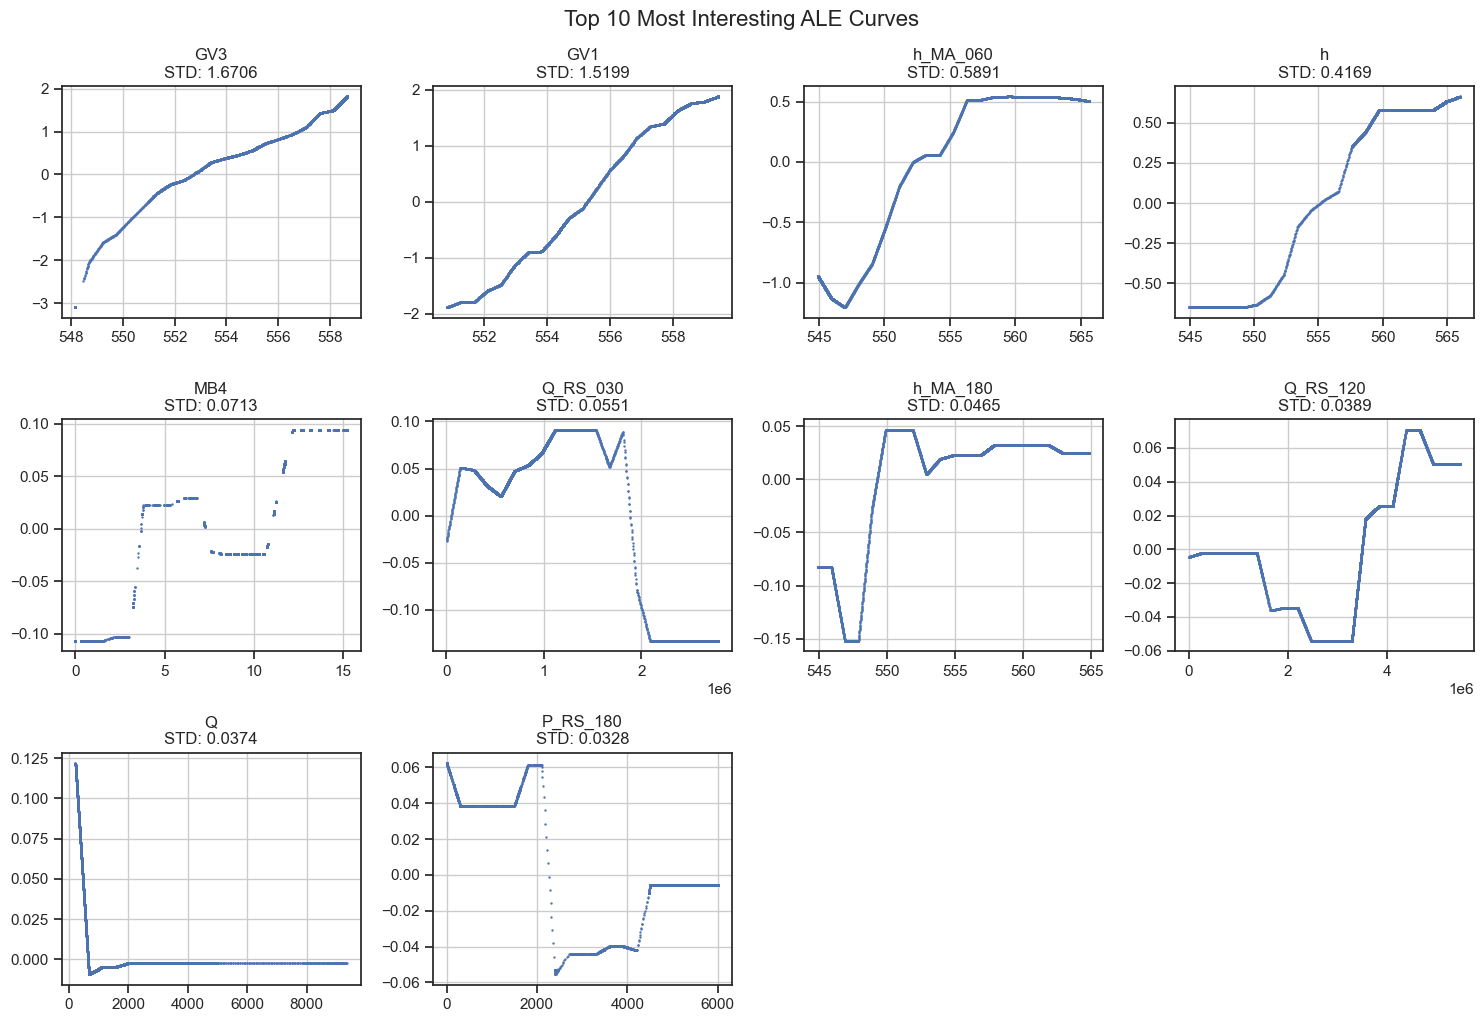

In [20]:
# Function to evaluate "interestingness" of features based on ALE standard deviation
def find_interesting_features(ALE, X, n_top=10):
    # Dictionary to store feature info
    feature_interest = {}
    
    # Loop through all features
    for i in range(len(X.columns)):
        feature_name = X.columns[i]
        
        try:
            # Get the feature values
            xs = X[feature_name].to_numpy()
            
            # Calculate ALE for this feature
            y_ALE = ALE.eval(i, xs=xs)
            
            # Calculate standard deviation as our "interestingness" metric
            ale_std = np.std(y_ALE)
            
            # Calculate min-max range as an alternative metric
            ale_range = np.max(y_ALE) - np.min(y_ALE)
            
            # Store results
            feature_interest[feature_name] = {
                'index': i,
                'std_dev': ale_std,
                'range': ale_range,
                'xs': xs,
                'ale_values': y_ALE
            }
            
            print(f"Feature {feature_name} (index {i}): STD = {ale_std:.4f}, Range = {ale_range:.4f}")
            
        except Exception as e:
            print(f"Error processing feature {feature_name} (index {i}): {e}")
    
    # Create a DataFrame for easy sorting and viewing
    results_df = pd.DataFrame([
        {'feature': fname, 'index': data['index'], 'std_dev': data['std_dev'], 'range': data['range']}
        for fname, data in feature_interest.items()
    ])
    
    # Sort by standard deviation (descending)
    top_by_std = results_df.sort_values('std_dev', ascending=False).head(n_top)
    
    # Sort by range (descending)
    top_by_range = results_df.sort_values('range', ascending=False).head(n_top)
    
    return {
        'all_results': results_df,
        'top_by_std': top_by_std,
        'top_by_range': top_by_range,
        'feature_data': feature_interest
    }

# Call the function
results = find_interesting_features(ALE, X_test, n_top=10)

# Display the top features by standard deviation
print("\nTop 10 features by standard deviation:")
print(results['top_by_std'])

# Display the top features by range
print("\nTop 10 features by range:")
print(results['top_by_range'])

# Plot the ALE curves for the top features
plt.figure(figsize=(15, 10))
for i, (_, row) in enumerate(results['top_by_std'].iterrows()):
    feature_name = row['feature']
    feature_data = results['feature_data'][feature_name]
    
    plt.subplot(3, 4, i+1)
    plt.scatter(feature_data['xs'], feature_data['ale_values'], s=0.5)
    plt.title(f"{feature_name}\nSTD: {row['std_dev']:.4f}")
    plt.grid(True)
    
plt.tight_layout()
plt.suptitle("Top 10 Most Interesting ALE Curves", y=1.02, fontsize=16)
plt.show()

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional, for progress tracking

# Function to evaluate "interestingness" of features based on ALE, with grouping support
def find_interesting_features_grouped(ALE, X_all, feature_groups=all_features_grouped, n_top=10):
    # Dictionary to store feature info
    feature_interest = {}
    
    # If no grouping is provided, treat each feature as its own group
    if feature_groups is None:
        feature_groups = {col: [col] for col in X_all.columns}
    
    # Create a mapping from individual features to their group
    feature_to_group = {}
    for group_name, features in feature_groups.items():
        for feature in features:
            feature_to_group[feature] = group_name
    
    # Dictionary to store group metrics
    group_metrics = {group: {'std_sum': 0, 'range_sum': 0, 'feature_count': 0, 'features': []} 
                    for group in feature_groups.keys()}
    
    # Loop through all features
    for i in range(len(X_all.columns)):
        feature_name = X_all.columns[i]
        
        try:
            # Get the feature values
            xs = X_all[feature_name].to_numpy()
            
            # Calculate ALE for this feature
            y_ALE = ALE.eval(i, xs=xs)
            
            # Calculate standard deviation and range
            ale_std = np.std(y_ALE)
            ale_range = np.max(y_ALE) - np.min(y_ALE)
            
            # Store individual feature results
            feature_interest[feature_name] = {
                'index': i,
                'std_dev': ale_std,
                'range': ale_range,
                'xs': xs,
                'ale_values': y_ALE,
                'group': feature_to_group.get(feature_name, 'Ungrouped')
            }
            
            # Add to group metrics
            group_name = feature_to_group.get(feature_name, 'Ungrouped')
            group_metrics[group_name]['std_sum'] += ale_std
            group_metrics[group_name]['range_sum'] += ale_range
            group_metrics[group_name]['feature_count'] += 1
            group_metrics[group_name]['features'].append(feature_name)
            
            print(f"Feature {feature_name} (index {i}, group {group_name}): STD = {ale_std:.4f}, Range = {ale_range:.4f}")
            
        except Exception as e:
            print(f"Error processing feature {feature_name} (index {i}): {e}")
    
    # Create DataFrames for individual features and groups
    feature_df = pd.DataFrame([
        {'feature': fname, 'group': data['group'], 'index': data['index'], 
         'std_dev': data['std_dev'], 'range': data['range']}
        for fname, data in feature_interest.items()
    ])
    
    group_df = pd.DataFrame([
        {'group': group, 
         'avg_std_dev': metrics['std_sum'] / max(1, metrics['feature_count']),
         'total_std_dev': metrics['std_sum'],
         'avg_range': metrics['range_sum'] / max(1, metrics['feature_count']),
         'total_range': metrics['range_sum'],
         'feature_count': metrics['feature_count'],
         'features': metrics['features']}
        for group, metrics in group_metrics.items()
    ])
    
    # Sort by different metrics
    top_groups_by_avg_std = group_df.sort_values('avg_std_dev', ascending=False).head(n_top)
    top_groups_by_total_std = group_df.sort_values('total_std_dev', ascending=False).head(n_top)
    top_features_by_std = feature_df.sort_values('std_dev', ascending=False).head(n_top)
    
    return {
        'feature_results': feature_df,
        'group_results': group_df,
        'top_groups_by_avg_std': top_groups_by_avg_std,
        'top_groups_by_total_std': top_groups_by_total_std,
        'top_features_by_std': top_features_by_std,
        'feature_data': feature_interest
    }

# Call the function with grouping
results = find_interesting_features_grouped(ALE, X_all, feature_groups=all_features_grouped, n_top=10)

# Display the top feature groups by average standard deviation
print("\nTop feature groups by average standard deviation:")
print(results['top_groups_by_avg_std'][['group', 'avg_std_dev', 'feature_count']])

# Plot the ALE curves for the most interesting group
most_interesting_group = results['top_groups_by_avg_std'].iloc[0]['group']
group_features = results['top_groups_by_avg_std'].iloc[0]['features']

Feature t (index 0, group Time-related features): STD = 0.0000, Range = 0.0000
Feature month (index 1, group Time-related features): STD = 0.0013, Range = 0.0046
Feature GV1 (index 2, group GV1): STD = 1.3756, Range = 3.7740
Feature GV3 (index 3, group GV3): STD = 1.7922, Range = 4.9219
Feature MB4 (index 4, group MB4): STD = 0.0599, Range = 0.2011
Feature MB8 (index 5, group MB8): STD = 0.0225, Range = 0.0701
Feature MB10 (index 6, group MB10): STD = 0.0062, Range = 0.0222
Feature MB18 (index 7, group MB18): STD = 0.0202, Range = 0.0513
Feature h (index 8, group Reservoir level): STD = 0.4879, Range = 1.3154
Feature h_MA_060 (index 9, group Reservoir level): STD = 0.5355, Range = 1.7467
Feature h_MA_180 (index 10, group Reservoir level): STD = 0.0279, Range = 0.1987
Feature TA (index 11, group Air Temperature): STD = 0.0126, Range = 0.0349
Feature TA_MA_180 (index 12, group Air Temperature): STD = 0.0256, Range = 0.0862
Feature TA_lag_060 (index 13, group Lagged Air Temperature): STD 

In [ ]:
all_features_grouped

{'Reservoir level': ['h', 'h_MA_060', 'h_MA_180'],
 'Precipitation': ['P'],
 'Accumulated precipitation 90 days': ['P_RS_090'],
 'Accumulated precipitation 180 days': ['P_RS_180'],
 'Air Temperature': ['TA', 'TA_MA_060', 'TA_MA_180'],
 'Lagged Air Temperature': ['TA_lag_060', 'TA_lag_090', 'TA_lag_120'],
 'Water Temperature': ['TW', 'TW_MA_120'],
 'Local Inflow': ['Q'],
 'Accumulated inflow 90 days': ['Q_RS_090'],
 'Accumulated inflow 180 days': ['Q_RS_180'],
 'Time-related features': ['t', 'month'],
 'GV1': ['GV1'],
 'GV3': ['GV3'],
 'MB4': ['MB4'],
 'MB8': ['MB8'],
 'MB10': ['MB10'],
 'MB18': ['MB18']}

## PyALE

In [13]:
from PyALE import ale

In [18]:
print(X.columns)

Index(['t', 'month', 'h', 'h_MA_060', 'h_MA_180', 'TA', 'TA_MA_180',
       'TA_lag_060', 'TA_lag_090', 'P', 'P_RS_180', 'Q', 'Q_RS_030',
       'Q_RS_120'],
      dtype='object')


PyALE._ALE_generic:INFO: Discrete feature detected.


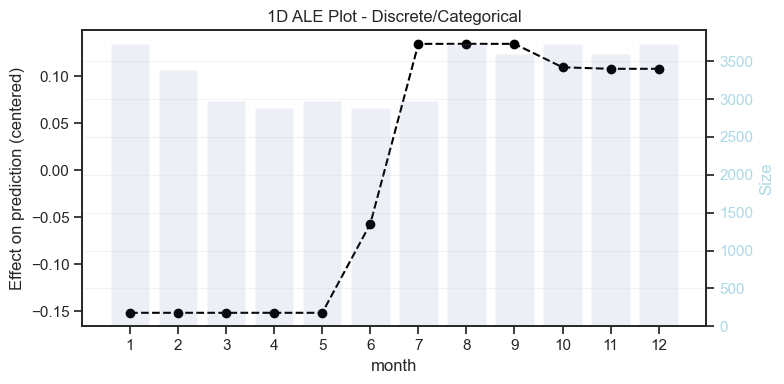

In [20]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X, model=model, feature=["month"], grid_size=30, include_CI=False
)
plt.gca()
plt.grid(alpha=.2)
plt.axhline(y=0, color='gray', alpha=.3, linestyle='--')
plt.show()

PyALE._ALE_generic:INFO: Continuous feature detected.


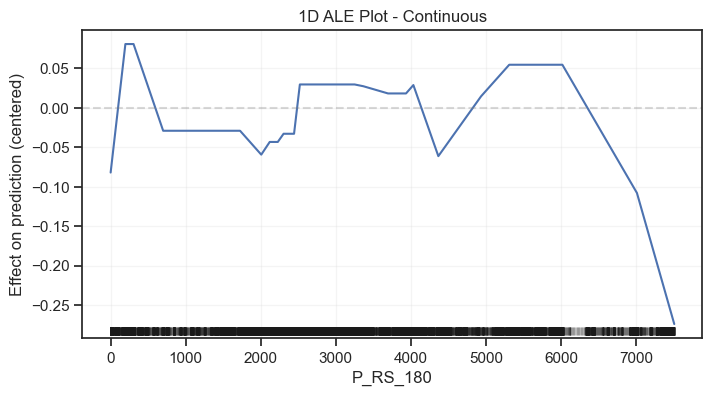

In [21]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X, model=model, feature=["P_RS_180"], grid_size=30, include_CI=False
)
plt.gca()
plt.grid(alpha=.2)
plt.axhline(y=0, color='gray', alpha=.3, linestyle='--')
plt.show()

## AlibiExplain

In [46]:
import alibi
from alibi.explainers import ALE
from alibi.explainers import plot_ale

In [50]:
model

LGBMRegressor(colsample_bytree=0.8552996267089586,
              learning_rate=0.03286202028083, linear_tree=False, max_depth=6,
              min_split_gain=0.6280661793078444, n_estimators=2951,
              num_leaves=3, reg_alpha=2.5137862899800223,
              reg_lambda=3.9430716192876, subsample=0.49235297280952,
              verbose=-1)